<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/04_transfer_learning_in_tensorflow_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture **proven to work** on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned patterns** on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0
TensorFlow Hub version: 0.16.1


In [2]:
!nvidia-smi

Mon May 12 21:50:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Downloading and becoming one with the data

In [3]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-05-12 21:50:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 9.3s    

2025-05-12 21:50:31 (17.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stoppping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
# import datetime

# def create_tensorboard_callback(dir_name, experiment_name):
#   log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#   tesorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
#   print(f"Saving TensorBoard log files to: {log_dir}")
#   return tesorboard_callback

# Don't need it

## Creating models using **TensorFlow Hub**

Here, we're not going to build our model from scratch. Majority of our model's layers will coming from `TensorFlow Hub`.
We can access pretrained models on: [tensorflow.org/hub](https://www.tensorflow.org/hub)




In [7]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1"

efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"

mobilenet_url = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/1"

In [8]:
# Install Weights and Biases
!pip install wandb

In [22]:
# Weights and Biases related imports
import wandb
from wandb.integration.keras import WandbCallback

**Run this when it's first time using W&B or we are not logged in.**

In [10]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: masrik-hasnat (masrik-hasnat-mh-tree) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

**Custom wrapper layer so Sequential accepts it**: Use the code from [stackoverflow](https://stackoverflow.com/questions/78530756/error-only-instances-of-keras-layer-can-be-added-to-a-sequential-model) to solve the problem of Sequential accepting the layers from `resnet_url`

In [54]:
# Import the dependencies
from tensorflow.keras import layers
import tensorflow_hub as hub
import tf_keras as keras
IMAGE_SHAPE = (224, 224)

In [12]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes):
  """
  Takes a URL and creates a Keras Sequential model with it
  Arguments:
    model_url(str) : Link to the model
    num_classes(int) : Number of output neurons in the output layer, should be equal to the number of target classes, default = 10
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
  """
  # Downlaod the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable = False,  #False in order to freeze the already learnt patterns.
                                            name = "feature_extraction_layer",
                                            input_shape = IMAGE_SHAPE + (3, ))

  # Custom wrapper layer so Sequential accepts it
  # class ResNetV2FeatureLayer(tf.keras.layers.Layer):
  #   def call(self, inputs):
  #     return feature_extraction_layer(inputs)

  # Create our own model
  # model = keras.Sequential([
  #     tf.keras.Input(shape=IMAGE_SHAPE+(3,), name="input_image"),
  #     ResNetV2FeatureLayer(), # Wrapped feature extractor
  #     layers.Dense(num_classes, activation = "softmax", name= "output_layer")
  # ])
  model = keras.Sequential([
      feature_extractor_layer,
      keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing **ResNet50** TensorFlow Hub Feature Extraction model

In [13]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [14]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [25]:
# Let's fit our ResNet model to the data (10 percent of 10 classes) with Wandb logging
wandb.init(project="classification_with_10percent_train_data", name="resnet50V2")

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[WandbCallback()])

# Close the W&B run
wandb.finish()

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.2091 - accuracy: 0.5560

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_221949-zmj7aiom/files/model-best)... Done. 0.4s


24/24 [==============================] - 23s 981ms/step - loss: 2.2091 - accuracy: 0.5560 - val_loss: 2.1975 - val_accuracy: 0.5568
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 2.1959 - accuracy: 0.5760

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_221949-zmj7aiom/files/model-best)... Done. 0.3s


24/24 [==============================] - 20s 885ms/step - loss: 2.1959 - accuracy: 0.5760 - val_loss: 2.1827 - val_accuracy: 0.5848
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 2.1787 - accuracy: 0.5813

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_221949-zmj7aiom/files/model-best)... Done. 0.3s


24/24 [==============================] - 22s 966ms/step - loss: 2.1787 - accuracy: 0.5813 - val_loss: 2.1649 - val_accuracy: 0.6040
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 2.1662 - accuracy: 0.6093

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_221949-zmj7aiom/files/model-best)... Done. 0.3s


24/24 [==============================] - 24s 1s/step - loss: 2.1662 - accuracy: 0.6093 - val_loss: 2.1526 - val_accuracy: 0.5972
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 2.1489 - accuracy: 0.6200

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_221949-zmj7aiom/files/model-best)... Done. 0.3s


24/24 [==============================] - 21s 902ms/step - loss: 2.1489 - accuracy: 0.6200 - val_loss: 2.1328 - val_accuracy: 0.6252


accuracy,▁▃▄▇█
epoch,▁▃▅▆█
loss,█▆▄▃▁
val_accuracy,▁▄▆▅█
val_loss,█▆▄▃▁
accuracy,0.62
best_epoch,4
best_val_loss,2.13282
epoch,4
loss,2.14894
val_accuracy,0.6252


In [26]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              25612201  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


Our transfer learning feature extractor model out performed all of the previous models we build by hand. And with only 10% of the training examples.

Tidbit: we could put a function like this into a script called "helper.py" and import it when it needed.

In [27]:
# Let's create a function to plot loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

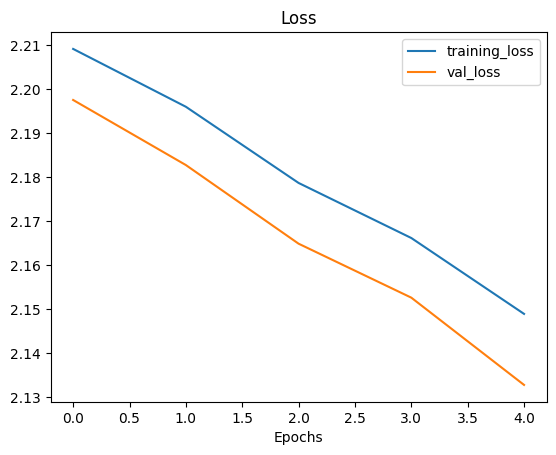

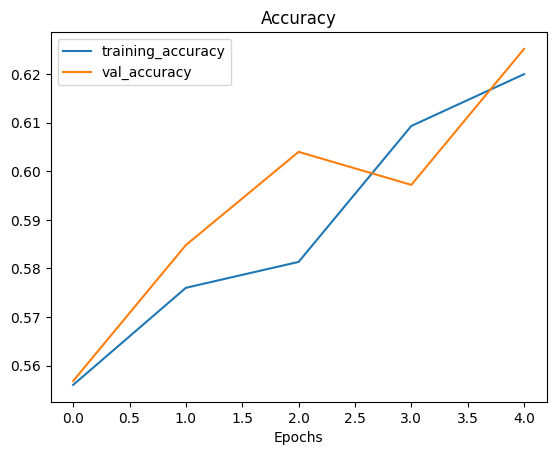

In [28]:
plot_loss_curves(resnet_history)

### Creating and testing **EfficientNetB0** TensorFlow Hub Feature Extraction model

In [55]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=keras.optimizers.Adam(),
                           metrics=["accuracy"])


ValueError: Could not interpret optimizer identifier: <tf_keras.src.optimizers.adam.Adam object at 0x7aca9a9000d0>

In [30]:
# Fit EfficientNet model to 10% of training data with Wandb logging
wandb.init(project="classification_with_10percent_train_data", name="efficientnetB0")

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[WandbCallback()])

# Close the W&B run
wandb.finish()

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9768 - accuracy: 0.3827

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_222200-21pe2vsn/files/model-best)... Done. 0.1s


24/24 [==============================] - 34s 1s/step - loss: 1.9768 - accuracy: 0.3827 - val_loss: 1.2340 - val_accuracy: 0.5996
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.0596 - accuracy: 0.6813

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_222200-21pe2vsn/files/model-best)... Done. 0.1s


24/24 [==============================] - 18s 799ms/step - loss: 1.0596 - accuracy: 0.6813 - val_loss: 0.9171 - val_accuracy: 0.6840
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.7560

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_222200-21pe2vsn/files/model-best)... Done. 0.1s


24/24 [==============================] - 19s 807ms/step - loss: 0.7912 - accuracy: 0.7560 - val_loss: 0.8402 - val_accuracy: 0.7136
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.8067

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_222200-21pe2vsn/files/model-best)... Done. 0.1s


24/24 [==============================] - 22s 956ms/step - loss: 0.6324 - accuracy: 0.8067 - val_loss: 0.7541 - val_accuracy: 0.7348
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.8413

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20250512_222200-21pe2vsn/files/model-best)... Done. 0.1s


24/24 [==============================] - 18s 764ms/step - loss: 0.5464 - accuracy: 0.8413 - val_loss: 0.7318 - val_accuracy: 0.7552


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▁▁
accuracy,0.84133
best_epoch,4
best_val_loss,0.73182
epoch,4
loss,0.54641
val_accuracy,0.7552


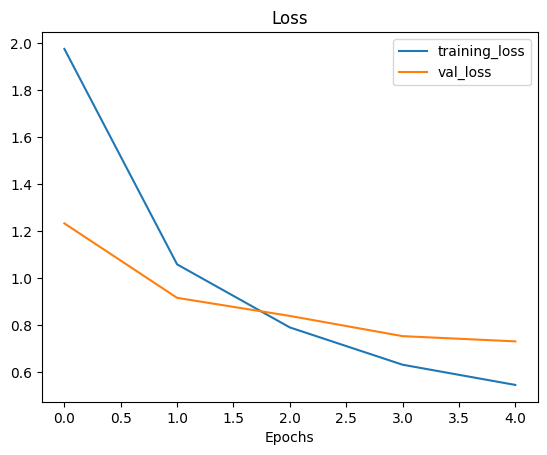

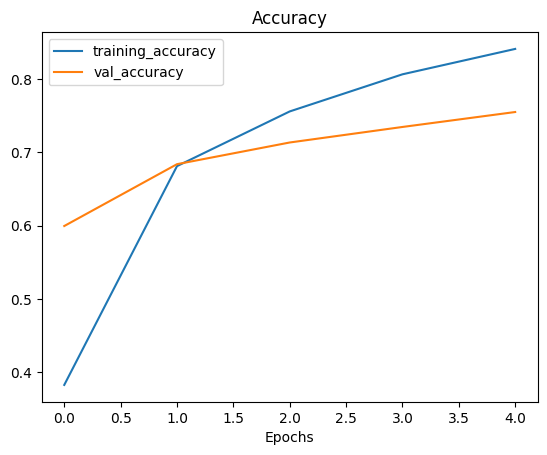

In [31]:
plot_loss_curves(efficientnet_history)

In [32]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              7200312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 7210322 (27.51 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


In [33]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              25612201  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


In [34]:
# How many layers does our efficientnetb0 feature extractor have
len(efficientnet_model.layers[0].weights)

361

### Creating and testing **MobileNet** TensorFlow Hub Feature Extraction model

In [52]:
# Create MobileNet feature extractor model
mobilenet_model = create_model(model_url=mobilenet_url,
                               num_classes=train_data_10_percent.num_classes)

# Compile MobileNet model
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(),
                        metrics=["accuracy"])

ValueError: Could not interpret optimizer identifier: <tf_keras.src.optimizers.adam.Adam object at 0x7acbb041dd50>

In [ ]:
# Fit MobileNet model to 10% of training data with Wandb logging
wandb.init(project="classification_with_10percent_train_data", name="mobilenet")

mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[WandbCallback()])

# Close the W&B run
wandb.finish()

In [ ]:
plot_loss_curves(mobilenet_history)

In [ ]:
mobilenet_model.summary()

Evaluation

In [ ]:
num_test_samples = test_data.samples
print(f"Total number of test samples: {num_test_samples}")

batch_size = test_data.batch_size
steps = (num_test_samples // batch_size) + int(num_test_samples % batch_size != 0)
print(f"Total steps for evaluation: {steps}")

resnet_results = resnet_model.evaluate(test_data, steps=steps)
mobilenet_results = mobilenet_model.evaluate(test_data, steps=steps)
efficientnet_results = efficientnet_model.evaluate(test_data, steps=steps)

resnet_accuracy = resnet_results[1]
mobilenet_accuracy = mobilenet_results[1]
efficientnet_accuracy = efficientnet_results[1]

print(f"Resnet accuracy: {resnet_accuracy:.4f}")
print(f"MobileNet accuracy: {mobilenet_accuracy:.4f}")
print(f"EfficientNet accuracy: {efficientnet_accuracy:.4f}")

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of our own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for our own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

# Comparing our model's results using TensorBoard **TensorBoard is shutdown. We use W&B for our model.**

> 🔑**Note:** When we upload things to `TensorBoard.dev`, our experiments are public. So, if we're running private experiments, we won't upload them to `TensorBoard.dev` to avoid getting public.

In [35]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2025-05-12 22:24:37.256190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747088677.277244   10214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747088677.283147   10214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [36]:
# Check out what TensorBoard experiments we have
!tensorboard dev list

2025-05-12 22:24:43.159866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747088683.179992   10246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747088683.185703   10246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


# Let's import data from W&B

In [43]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

# Import W&B api
api = wandb.Api()

In [45]:
# Define the project path, fetch all finished runs and metric history
project_path = "masrik-hasnat-mh-tree/classification_with_10percent_train_data"

metrics_all_runs = {}

runs = api.runs(project_path)
for run in runs:
  if run.state == "finished":
    try:
      history = run.history(keys=["epoch", "accuracy", "val_accuracy","loss", "val_loss"])
      history["run_name"] = run.name
      metrics_all_runs[run.name] = history
    except:
      continue

In [ ]:
for run_name, df in metrics_all_runs.items():
    print(f"\n📊 Run: {run_name}")
    display(df[["epoch", "accuracy", "val_accuracy", "loss", "val_loss"]])


In [46]:
# Display the result of different model in Tables
for run_name, df in metrics_all_runs.items():
  print(f"\nRun: {run_name}")
  display(df[["epoch", "accuracy", "val_accuracy", "loss", "val_loss"]])


Run: resnet50V2


,epoch,accuracy,val_accuracy,loss,val_loss
0,0,0.556000,0.5568,2.209067,2.197481
1,1,0.576000,0.5848,2.195940,2.182715
2,2,0.581333,0.6040,2.178652,2.164868
3,3,0.609333,0.5972,2.166156,2.152621
4,4,0.620000,0.6252,2.148939,2.132820



Run: efficientnetB0


,epoch,accuracy,val_accuracy,loss,val_loss
0,0,0.382667,0.5996,1.976837,1.234022
1,1,0.681333,0.6840,1.059591,0.917084
2,2,0.756000,0.7136,0.791174,0.840189
3,3,0.806667,0.7348,0.632424,0.754118
4,4,0.841333,0.7552,0.546412,0.731815


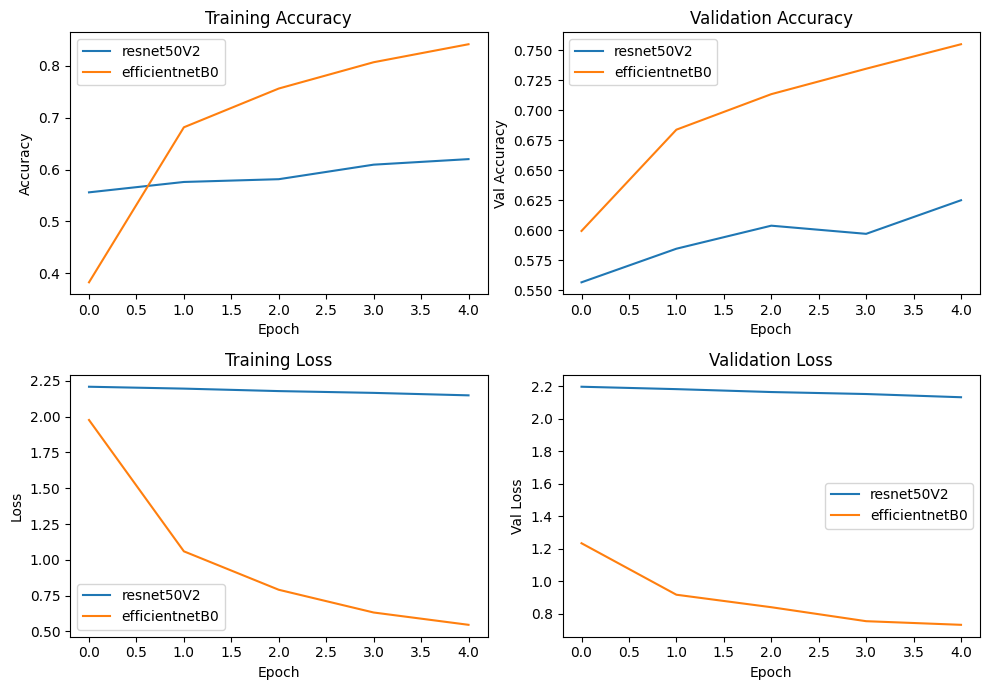

In [47]:
# Plotting Comparison Across Runs
plt.figure(figsize=(10, 7))

# Accuracy
plt.subplot(2, 2, 1)
for run_name, df in metrics_all_runs.items():
  plt.plot(df["epoch"], df["accuracy"], label=run_name)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 2)
for run_name, df in metrics_all_runs.items():
  plt.plot(df["epoch"], df["val_accuracy"], label=run_name)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()

# Training Loss
plt.subplot(2, 2, 3)
for run_name, df in metrics_all_runs.items():
  plt.plot(df["epoch"], df["loss"], label=run_name)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Validation Loss
plt.subplot(2, 2, 4)
for run_name, df in metrics_all_runs.items():
  plt.plot(df["epoch"], df["val_loss"], label=run_name)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.legend()

plt.tight_layout()
plt.show()

# EXTRA: Code for import through applications

In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained ResNet50 model, excluding the top (classification) layer
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze ResNet layers to prevent them from being trained
for layer in resnet_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add ResNet as the first layer
model.add(resnet_model)

# Add Flatten layer to convert ResNet output to a 1D vector
model.add(Flatten())

# Add Dense layers for classification or other tasks
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Example: 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,280,650 (187.99 MB)

 Trainable params: 25,692,938 (98.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Print versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("TF Hub version:", hub.__version__)

# Constants
IMAGE_SHAPE = (224, 224)

# Wrapper Layer for TF Hub
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=False, name="hub_layer", **kwargs):
        super().__init__(name=name, **kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Function to create the model
def create_model(model_url, num_classes=10):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=IMAGE_SHAPE + (3,), name="input_image"),
        HubLayerWrapper(model_url, trainable=False, name="feature_extractor"),
        layers.Dense(num_classes, activation='softmax', name="output_layer")
    ])
    return model

# Example usage
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Show model summary
model.summary()


TensorFlow version: 2.18.0
Keras version: 3.8.0
TF Hub version: 0.16.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor               │ (None, 2048)           │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
import tensorflow_hub as hub
import tf_keras as keras
from tf_keras import layers

# Define image input shape
IMAGE_SHAPE = (224, 224)

# TF Hub link for ResNetV2
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Load feature extractor layer from TensorFlow Hub
resnet_feature_extractor = hub.KerasLayer(resnet_url,
                                          input_shape=IMAGE_SHAPE + (3,),
                                          trainable=False,
                                          name="resnet_v2_feature_extractor")

# Wrap it in a custom layer for Sequential compatibility
class ResNetV2FeatureLayer(layers.Layer):
    def call(self, inputs):
        return resnet_feature_extractor(inputs)

# Define the model
model = keras.Sequential([
    layers.Input(shape=(224, 224, 3), name="input_image"),
    ResNetV2FeatureLayer(),  # Custom wrapper layer
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax', name='output')  # 10-class classification
])

# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_v2_feature_layer (  (None, 2048)              0         
 ResNetV2FeatureLayer)                                           
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 271178 (1.03 MB)
Trainable params: 271178 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Define a custom layer that wraps the TensorFlow Hub KerasLayer
class ResNetFeatureExtractor(layers.Layer):
    def __init__(self, model_url, **kwargs):
        super(ResNetFeatureExtractor, self).__init__(**kwargs)
        self.feature_extractor = hub.KerasLayer(
            model_url,
            trainable=False,
            name="resnet_feature_extractor"
        )

    def call(self, inputs):
        return self.feature_extractor(inputs)

# Define the model
def create_model(model_url, num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=(224, 224, 3), name='input_image'),
        ResNetFeatureExtractor(model_url),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model

# Example usage
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
num_classes = 10  # Replace with the actual number of classes in your dataset
model = create_model(resnet_url, num_classes)

# Display the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net_feature_extractor       │ (None, 2048)           │             0 │
│ (ResNetFeatureExtractor)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,178 (1.03 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 0 (0.00 B)